<a href="https://colab.research.google.com/github/AakankshaGupta16/PEAR-LEAF-ML-DL/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import drive

# Define the dataset path (update this path to your dataset's location in Google Drive)
DATASET_PATH = '/content/drive/MyDrive/pear'

# Specify the shape of the inputs for our network
IMG_SHAPE = (128, 128, 3)

# Specify the batch size and number of epochs
BATCH_SIZE = 16
EPOCHS = 20

# Define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/output"

# Use the base output path to derive the path to the serialized model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "combined_scnn_vae_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "combined_plot.png"])

# Function to load images from a directory and their labels
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            class_names.append(label)
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=(IMG_SHAPE[0], IMG_SHAPE[1]))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load the dataset
print("[INFO] loading pear leaf dataset...")
images, labels, class_names = load_images_from_folder(DATASET_PATH)

# Normalize the images
images = images / 255.0

# Encode the labels as integers
label_mapping = {label: idx for idx, label in enumerate(class_names)}
labels = np.array([label_mapping[label] for label in labels])

# Save the class names to a file for later use
class_names_path = os.path.sep.join([BASE_OUTPUT, "class_names.txt"])
with open(class_names_path, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

# Print the class names
print("[INFO] Class names:", class_names)

# Split the dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)


[INFO] loading pear leaf dataset...
[INFO] Class names: ['curl', 'healthy', 'spot', 'slug']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda, concatenate
import tensorflow.keras.backend as K

# Latent dimension for VAE (updated to include SCNN encodings)
#latent_dim = 48 + 2 * 48  # Original latent_dim + 2 * SCNN embedding dim
latent_dim = 1

# Function to build the SCNN feature extractor
def build_scnn_feature_extractor(inputShape, embeddingDim=48):
    inputs = Input(inputShape)

    # First set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    pooledOutput1 = GlobalAveragePooling2D()(x)
    encoded1 = Dense(embeddingDim, name='dense')(pooledOutput1)

    # Second set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput2 = GlobalAveragePooling2D()(x)
    encoded2 = Dense(embeddingDim, name='dense_1')(pooledOutput2)

    # Concatenate both encoders
    concatenated = concatenate([encoded1, encoded2])

    model = Model(inputs, concatenated)
    return model

# Sampling function (from VAE)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_combined_model(inputShape, latent_dim):
    # Inputs
    imgA = Input(shape=inputShape)
    imgB = Input(shape=inputShape)

    # SCNN feature extractor (shared weights)
    scnn_feature_extractor = build_scnn_feature_extractor(inputShape)

    # Extract features
    featsA = scnn_feature_extractor(imgA)
    featsB = scnn_feature_extractor(imgB)

    # Concatenate features from both inputs
    concatenated = concatenate([featsA, featsB])

    # VAE layers
    x = Dense(256, activation='relu')(concatenated)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling
    z = Lambda(sampling)([z_mean, z_log_var])

    # Get SCNN encodings directly from the feature extractor
    scnn_encodings = scnn_feature_extractor(imgA)

    # Concatenate z with SCNN encodings
    enhanced_z = concatenate([z, scnn_encodings])

    # Decoder
    decoder_input = Input(shape=(latent_dim + 2*48,))  # 48 is the embedding dimension from SCNN
    x = Dense(256, activation='relu')(decoder_input)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(inputShape[0] * inputShape[1] * inputShape[2], activation='sigmoid')(x)
    decoded_reshaped = tf.keras.layers.Reshape(inputShape)(decoded)

    # Define models
    encoder = Model([imgA, imgB], [z_mean, z_log_var, enhanced_z], name='encoder')
    decoder = Model(decoder_input, decoded_reshaped, name='decoder')

    # Combined model
    outputs = decoder(encoder([imgA, imgB])[2])
    combined_model = Model([imgA, imgB], outputs, name='combined_scnn_vae')

    return combined_model, encoder, decoder



In [ ]:
def build_combined_model(inputShape, latent_dim):
    # Inputs
    imgA = Input(shape=inputShape)
    imgB = Input(shape=inputShape)

    # SCNN feature extractor (shared weights)
    scnn_feature_extractor = build_scnn_feature_extractor(inputShape)

    # Extract features
    featsA = scnn_feature_extractor(imgA)
    featsB = scnn_feature_extractor(imgB)

    # Concatenate features from both inputs
    concatenated = concatenate([featsA, featsB])

    # VAE layers
    x = Dense(256, activation='relu')(concatenated)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Sampling
    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # Get SCNN encodings directly from the feature extractor
    scnn_encodings = scnn_feature_extractor(imgA)

    # Concatenate z with SCNN encodings
    enhanced_z = concatenate([z, scnn_encodings], name='enhanced_z')

    # Decoder
    decoder_input = Input(shape=(latent_dim + 2*48,))  # 48 is the embedding dimension from SCNN
    x = Dense(256, activation='relu')(decoder_input)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(inputShape[0] * inputShape[1] * inputShape[2], activation='sigmoid')(x)
    decoded_reshaped = tf.keras.layers.Reshape(inputShape)(decoded)

    # Define models
    encoder = Model([imgA, imgB], [z_mean, z_log_var, z, scnn_encodings, enhanced_z], name='encoder')
    decoder = Model(decoder_input, decoded_reshaped, name='decoder')

    # Combined model
    outputs = decoder(encoder([imgA, imgB])[4])  # Use enhanced_z
    combined_model = Model([imgA, imgB], outputs, name='combined_scnn_vae')

    return combined_model, encoder, decoder

# Build the model
input_shape = (64, 64, 3)  # Adjust this to your actual input shape
latent_dim = 48 + 2 * 48
combined_model, encoder, decoder = build_combined_model(input_shape, latent_dim)

# Create some dummy data to test the model
dummy_imgA = np.random.rand(1, *input_shape)
dummy_imgB = np.random.rand(1, *input_shape)

# Run the encoder to get the values
z_mean, z_log_var, z, scnn_encodings, enhanced_z = encoder.predict([dummy_imgA, dummy_imgB])

print("Shape of z:", z.shape)
print("First few elements of z:", z[:25][:25])

print("\nShape of scnn_encodings:", scnn_encodings.shape)
print("First few elements of scnn_encodings:", scnn_encodings[:25][:25])

print("\nShape of enhanced_z:", enhanced_z.shape)
print("First few elements of enhanced_z:", enhanced_z[:25][:25])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Shape of z: (1, 144)
First few elements of z: [[ 6.7378497e-01 -8.4456474e-01 -2.6393628e-01  5.2149427e-01
  -2.5498509e+00  2.0759711e+00  1.5175288e+00  3.2287556e-01
  -1.0405587e+00  1.5185544e+00  7.2075260e-01  7.7877671e-02
  -2.2100292e-01  1.7235659e+00 -6.5614659e-01 -6.2637156e-01
  -6.0841453e-01  5.6151241e-01 -2.1338313e+00  4.9911547e-01
  -2.6522267e+00 -1.0458889e+00  1.8359879e+00 -3.6121225e-01
  -9.2981309e-01 -4.4719246e-01 -1.2968556e+00  1.0899752e+00
   4.2731151e-02 -3.5352898e-01 -1.1818709e+00 -1.0421940e+00
   3.6025321e-01 -1.4051427e+00 -1.8732651e+00 -3.0455557e-01
  -5.0516307e-01 -1.6094145e+00  3.2978979e-01  5.1662552e-01
  -6.0810423e-01 -1.8652594e+00 -1.2455928e+00 -6.1257577e-01
  -4.3739617e-01 -3.1436020e-01  1.4372967e-01  3.8037100e-01
  -7.1626884e-01  2.0033307e-01 -2.1136627e+00 -6.9435328e-02
  -1.3873711e+00  1.6592486e-01  1.3995957e+00  4.9487314e-01
   2.7031034e-01 -1.3384997e+00  2.0279481e+00 -1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


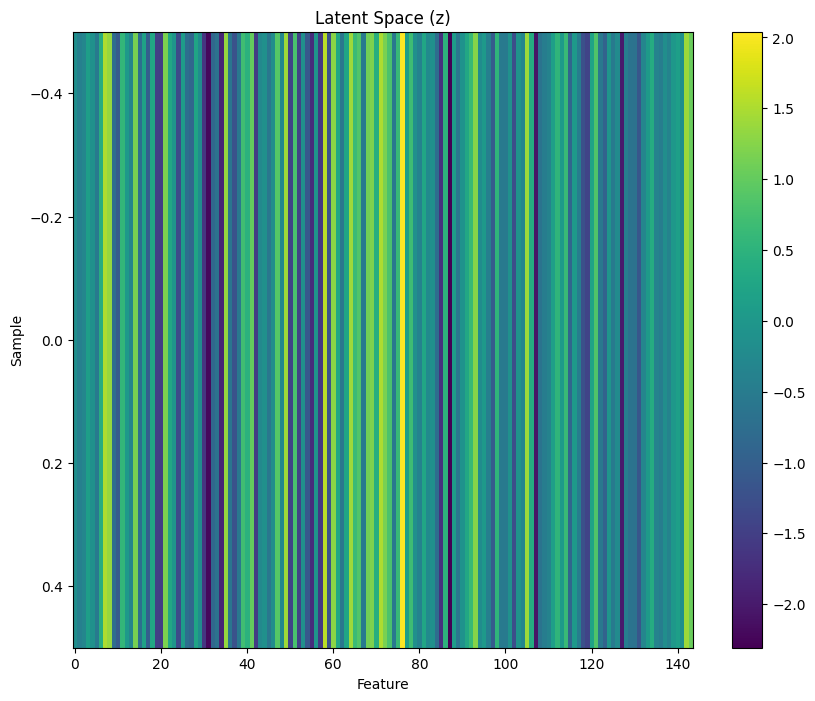

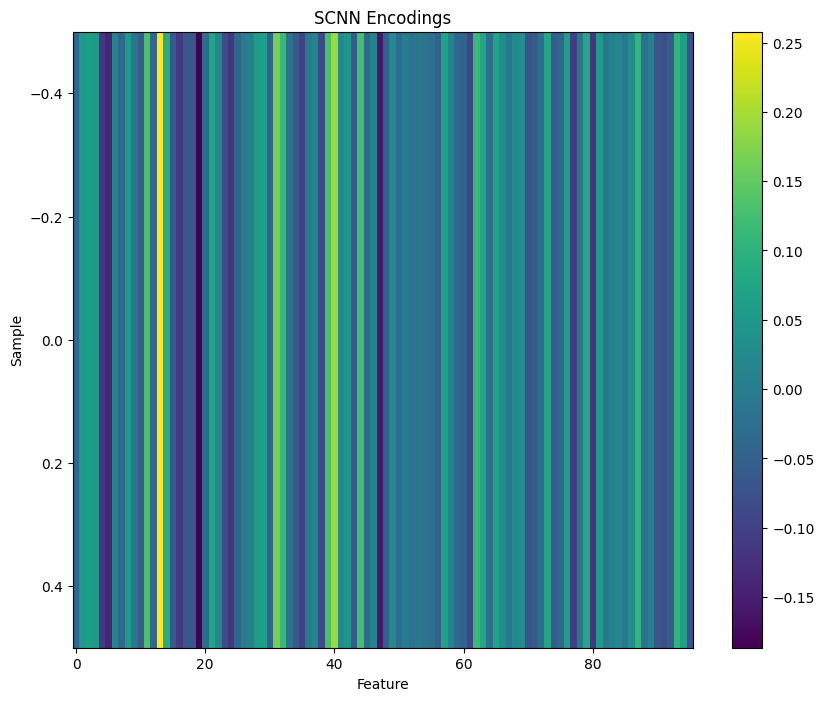

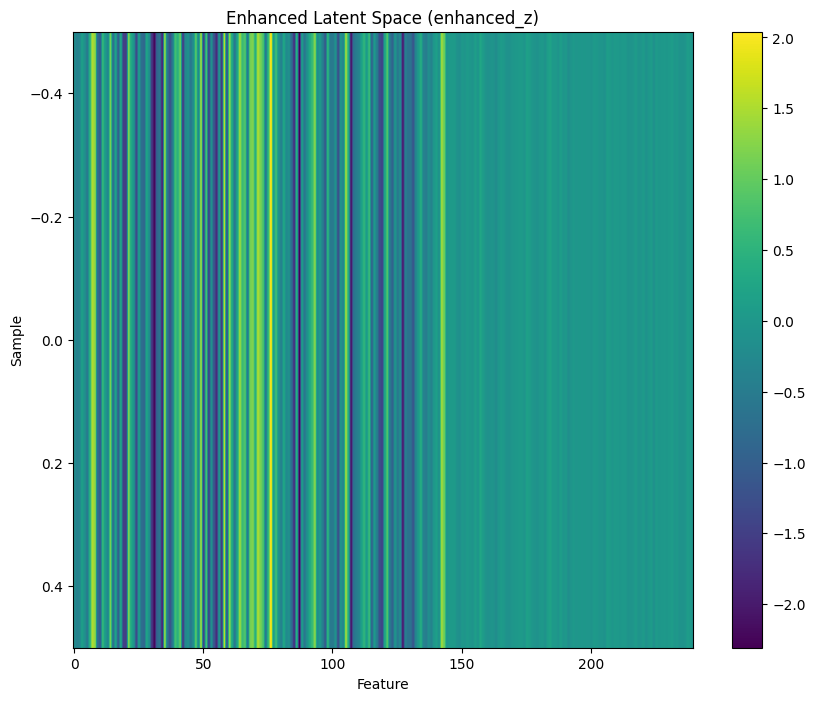

Shape of z: (1, 144)
Shape of scnn_encodings: (1, 96)
Shape of enhanced_z: (1, 240)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Build the model
input_shape = (64, 64, 3)  # Adjust this to your actual input shape
latent_dim = 48 + 2 * 48
combined_model, encoder, decoder = build_combined_model(input_shape, latent_dim)

# Create some dummy data to test the model
dummy_imgA = np.random.rand(1, *input_shape)
dummy_imgB = np.random.rand(1, *input_shape)

# Run the encoder to get the values
z_mean, z_log_var, z, scnn_encodings, enhanced_z = encoder.predict([dummy_imgA, dummy_imgB])

# Function to plot heatmap
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Feature')
    plt.ylabel('Sample')
    plt.show()

# Plot z
plot_heatmap(z, "Latent Space (z)")

# Plot scnn_encodings
plot_heatmap(scnn_encodings, "SCNN Encodings")

# Plot enhanced_z
plot_heatmap(enhanced_z, "Enhanced Latent Space (enhanced_z)")

# Print shapes
print("Shape of z:", z.shape)
print("Shape of scnn_encodings:", scnn_encodings.shape)
print("Shape of enhanced_z:", enhanced_z.shape)

In [ ]:
# Prepare the positive and negative pairs
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return (np.array(pairImages), np.array(pairLabels))

# Prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

# Build the combined SCNN-VAE model
print("[INFO] building combined SCNN-VAE network...")
combined_model, encoder, decoder = build_combined_model(IMG_SHAPE, latent_dim)


[INFO] preparing positive and negative pairs...
[INFO] building combined SCNN-VAE network...


In [ ]:
import tensorflow.keras.backend as K

# Loss function
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(
        K.flatten(inputs), K.flatten(outputs)) * IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# Compile the model
print("[INFO] compiling model...")
combined_model.compile(optimizer='adam', loss=lambda x, y: vae_loss(x, y, encoder([x, x])[0], encoder([x, x])[1]))

# Display model summaries
combined_model.summary()
encoder.summary()
decoder.summary()


[INFO] compiling model...


Model: "combined_scnn_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 144), (None,   │        212,736 │ input_layer_8[0][0],   │
│                           │ 144), (None, 144),     │                │ input_layer_9[0][0]    │
│                           │ (None, 96), (None,     │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 128, 128, 3)    │     25,408,256 │ encoder[0][4]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,620,992 (97.74 MB)

 Trainable params: 25,620,992 (97.74 MB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 96)             │         89,312 │ input_layer_8[0][0],   │
│                           │                        │                │ input_layer_9[0][0],   │
│                           │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 192)            │              0 │ functional_2[0][0],    │
│ (Concatenate)             │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │         49,408 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 144)            │         37,008 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 144)            │         37,008 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 144)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enhanced_z (Concatenate)  │ (None, 240)            │              0 │ z[0][0],               │
│                           │                        │                │ functional_2[2][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 212,736 (831.00 KB)

 Trainable params: 212,736 (831.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          61,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 49152)               │      25,214,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,408,256 (96.92 MB)

 Trainable params: 25,408,256 (96.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
print("[INFO] training model...")
history = combined_model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], pairTrain[:, 0],  # Use first image of pair as target
    validation_data=([pairTest[:, 0], pairTest[:, 1]], pairTest[:, 0]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Serialize the model to disk
print("[INFO] saving combined SCNN-VAE model...")
combined_model.save(MODEL_PATH)

# Plot the training history
print("[INFO] plotting training history...")
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

print("[INFO] Process completed successfully!")

[INFO] training model...


[INFO] displaying image pairs from the training set...


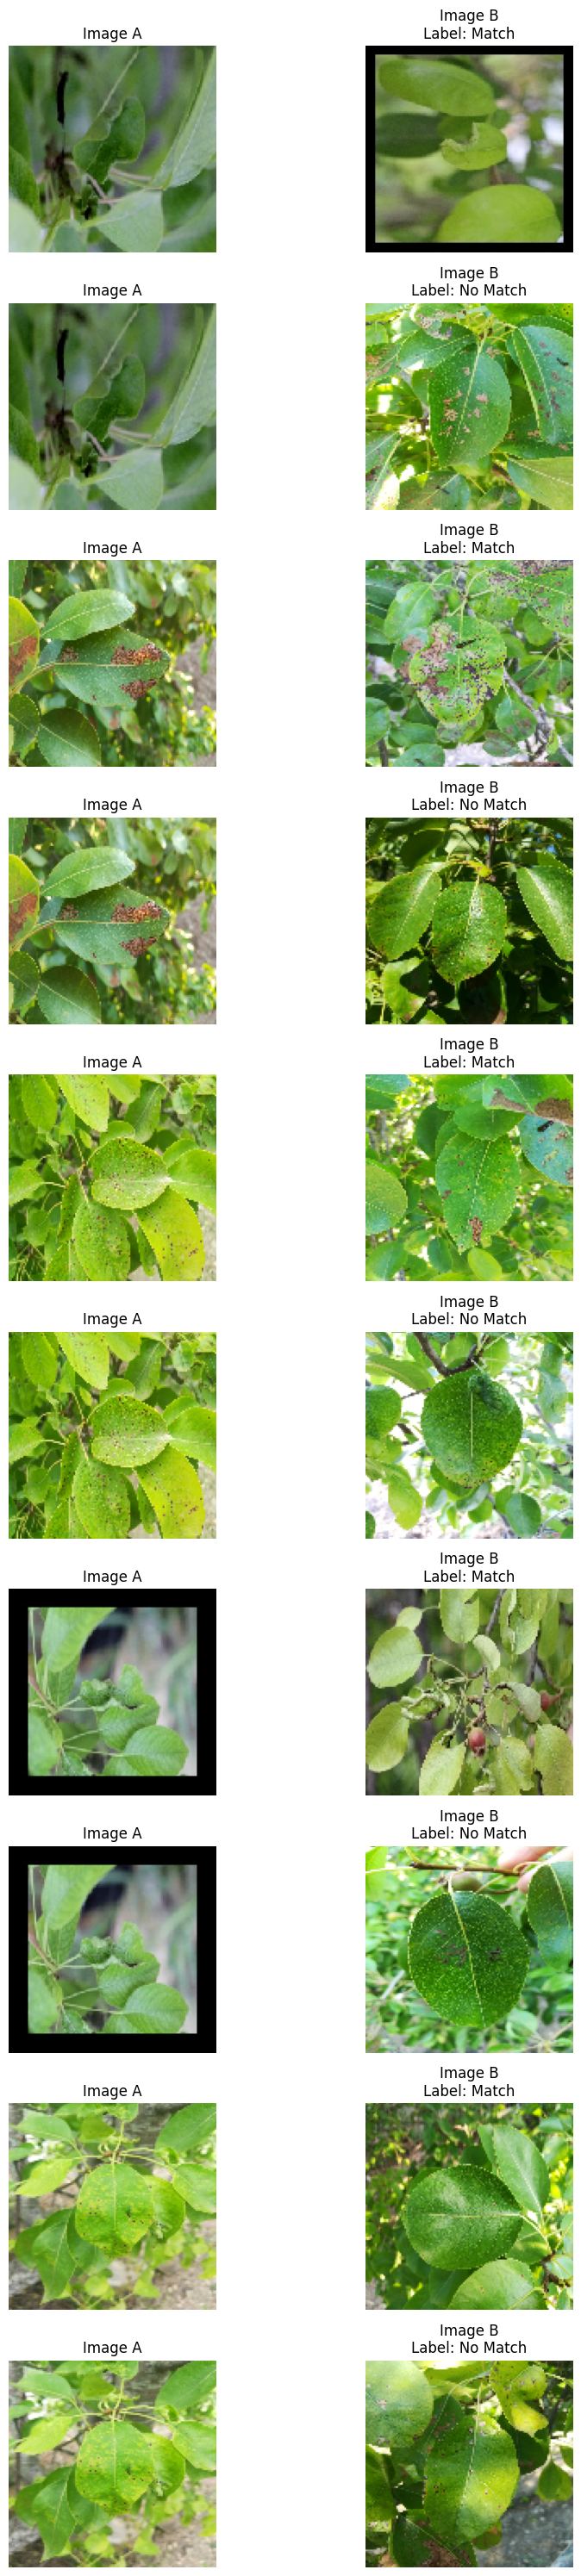

[INFO] displaying image pairs from the testing set...


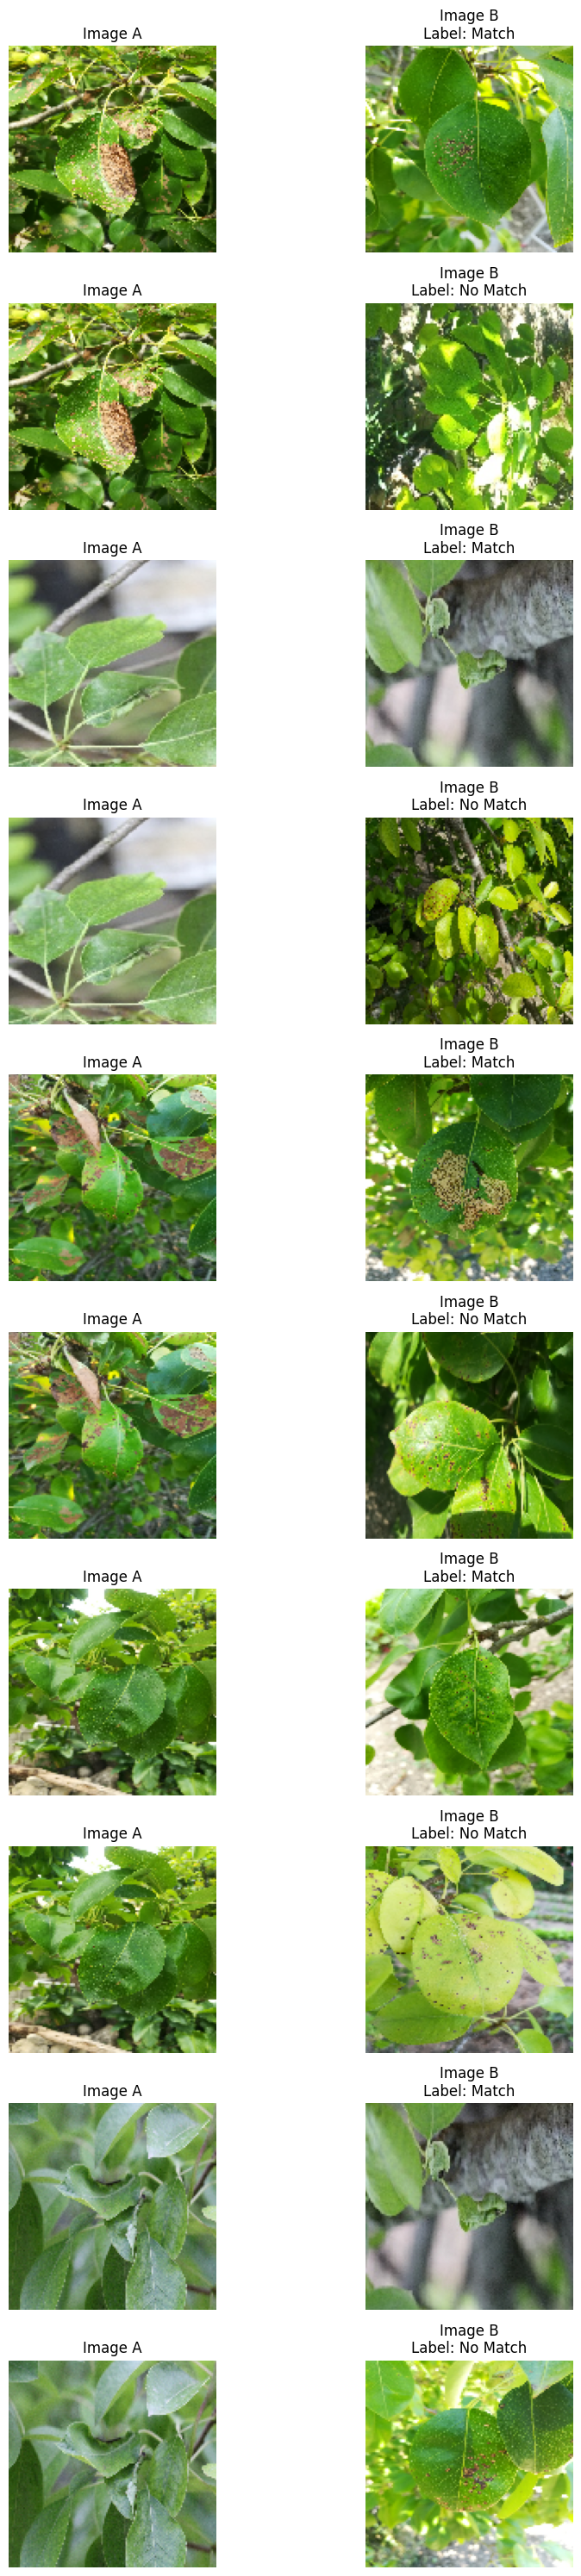

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
# Function to display image pairs with their labels
def display_image_pairs(pairs, labels, num=10):
    # Ensure the number of images to display does not exceed the length of pairs
    num = min(num, len(pairs))

    # Create a figure for the pairs
    fig, axes = plt.subplots(num, 2, figsize=(10, num * 3))

    for i in range(num):
        # Display the first image in the pair
        ax = axes[i, 0]
        ax.imshow(pairs[i, 0])
        ax.set_title("Image A")
        ax.axis("off")

        # Display the second image in the pair
        ax = axes[i, 1]
        ax.imshow(pairs[i, 1])
        ax.set_title("Image B\nLabel: {}".format("Match" if labels[i] == 1 else "No Match"))
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display some pairs from the training set
print("[INFO] displaying image pairs from the training set...")
display_image_pairs(pairTrain, labelTrain)

# Display some pairs from the testing set
print("[INFO] displaying image pairs from the testing set...")
display_image_pairs(pairTest, labelTest)

Accuracy: 53.58%
Label Dictionary:  {'curl': 0, 'healthy': 1, 'spot': 2, 'slug': 3}


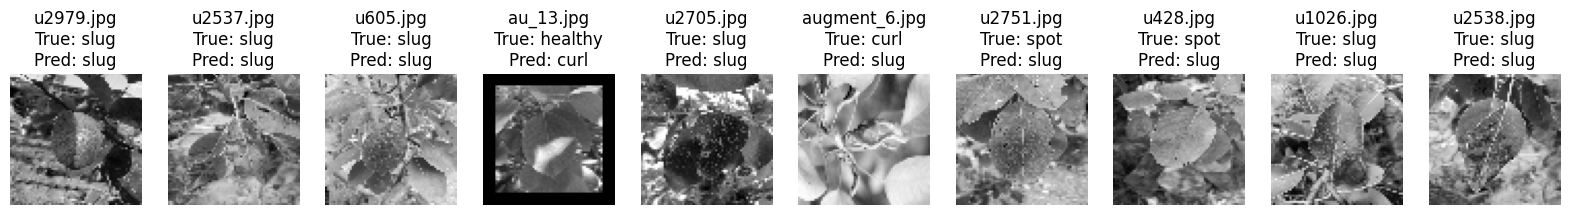

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = []
    label_dict = {}
    label_count = 0

    for subdir, dirs, files in os.walk(folder):
        for file in files:
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize the image to a fixed size (e.g., 64x64)
                img = cv2.resize(img, (64, 64))
                images.append(img.flatten())

                # Extract the label from the folder name
                label = os.path.basename(subdir)
                if label not in label_dict:
                    label_dict[label] = label_count
                    label_count += 1
                labels.append(label_dict[label])
                file_names.append(file)

    return np.array(images), np.array(labels), label_dict, file_names

# Load the dataset
folder_path = '/content/drive/MyDrive/pear'
X, y, label_dict, file_names = load_images_from_folder(folder_path)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, file_names_train, file_names_test = train_test_split(
    X, y, file_names, test_size=0.2, stratify=y, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=50)

# Create an SVM classifier with a linear kernel and one-vs-rest strategy
clf = make_pipeline(scaler, pca, svm.SVC(kernel='linear', decision_function_shape='ovr'))

# Train the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print label dictionary for reference
print("Label Dictionary: ", label_dict)

# Function to plot some classified images along with their file names
def plot_classified_images(X, y_true, y_pred, file_names, label_dict, n_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        idx = np.random.randint(0, len(y_true))
        img = X[idx].reshape(64, 64)
        true_label = [key for key, value in label_dict.items() if value == y_true[idx]][0]
        pred_label = [key for key, value in label_dict.items() if value == y_pred[idx]][0]
        file_name = file_names[idx]

        plt.subplot(1, n_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{file_name}\nTrue: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

# Plot some classified images
plot_classified_images(X_test, y_test, y_pred, file_names_test, label_dict, n_images=10)

[INFO] loading pear leaf dataset...
[INFO] compiling model...
[INFO] Extracting enhanced_z features...
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
[INFO] Training SVM classifier...
Accuracy: 73.09%

Classification Report:
              precision    recall  f1-score   support

        curl       0.84      0.88      0.86       119
     healthy       0.74      0.64      0.69       109
        spot       0.55      0.31      0.40       177
        slug       0.74      0.89      0.81       405

    accuracy                           0.73       810
   macro avg       0.72      0.68      0.69       810
weighted avg       0.71      0.73      0.71       810

[INFO] Plotting confusion matrix...


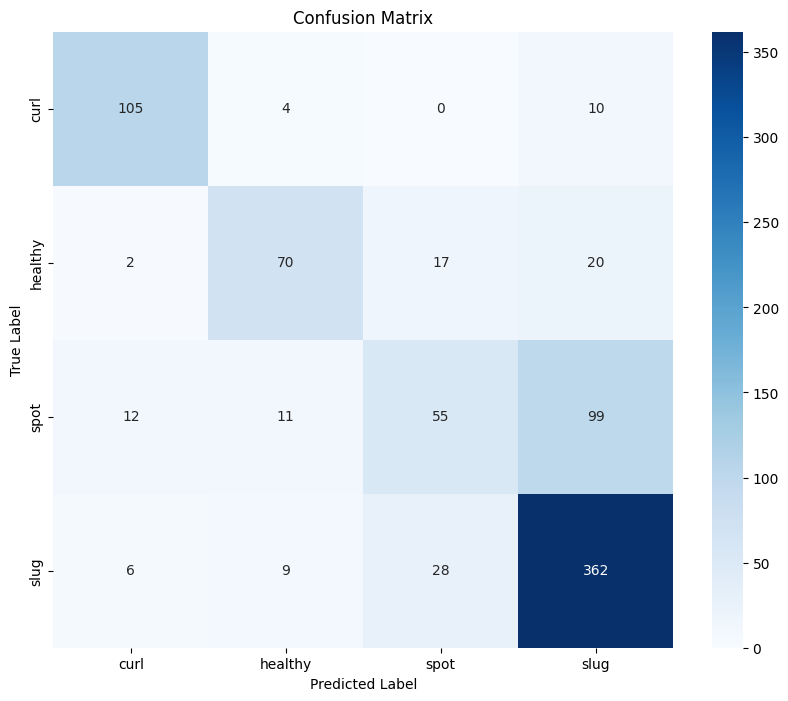

[INFO] Visualizing feature space...


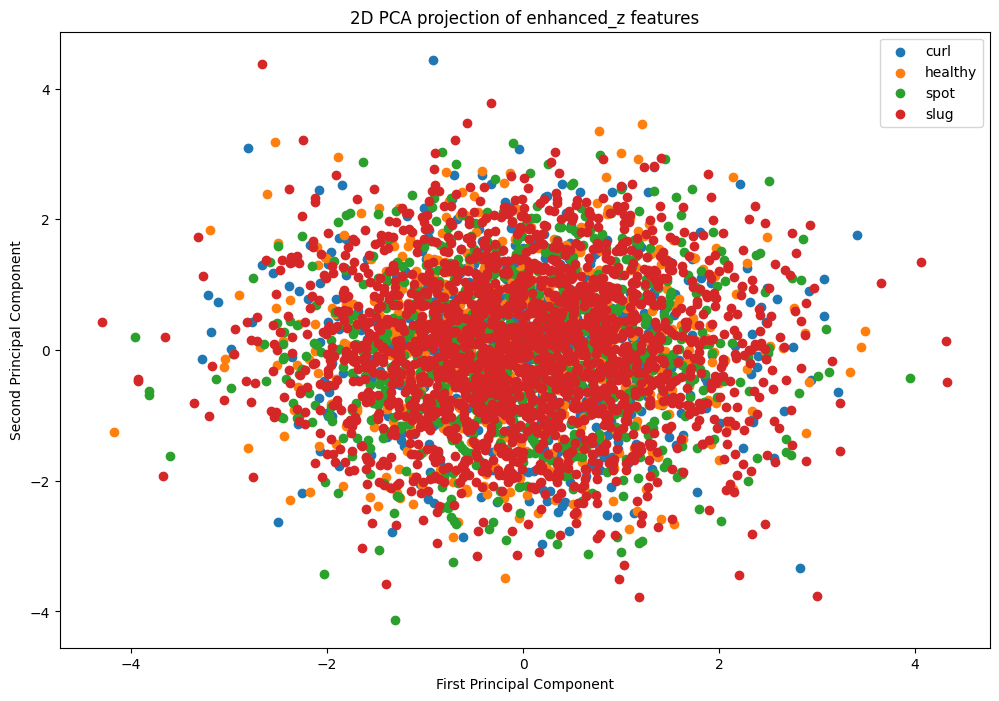

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda, concatenate
import tensorflow.keras.backend as K
import tensorflow as tf

# Define the dataset path (update this path to your dataset's location)
DATASET_PATH = '/content/drive/MyDrive/pear'

# Specify the shape of the inputs for our network
IMG_SHAPE = (128, 128, 3)

# Function to load images from a directory and their labels
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            class_names.append(label)
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=(IMG_SHAPE[0], IMG_SHAPE[1]))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load the dataset
print("[INFO] loading pear leaf dataset...")
images, labels, class_names = load_images_from_folder(DATASET_PATH)

# Normalize the images
images = images / 255.0

# Encode the labels as integers
label_mapping = {label: idx for idx, label in enumerate(class_names)}
labels = np.array([label_mapping[label] for label in labels])

# Function to build the SCNN feature extractor
def build_scnn_feature_extractor(inputShape, embeddingDim=48):
    inputs = Input(inputShape)

    # First set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    pooledOutput1 = GlobalAveragePooling2D()(x)
    encoded1 = Dense(embeddingDim, name='dense')(pooledOutput1)

    # Second set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput2 = GlobalAveragePooling2D()(x)
    encoded2 = Dense(embeddingDim, name='dense_1')(pooledOutput2)

    # Concatenate both encoders
    concatenated = concatenate([encoded1, encoded2])

    model = Model(inputs, concatenated)
    return model

# Sampling function (from VAE)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_combined_model(inputShape, latent_dim):
    # Inputs
    imgA = Input(shape=inputShape)
    imgB = Input(shape=inputShape)

    # SCNN feature extractor (shared weights)
    scnn_feature_extractor = build_scnn_feature_extractor(inputShape)

    # Extract features
    featsA = scnn_feature_extractor(imgA)
    featsB = scnn_feature_extractor(imgB)

    # Concatenate features from both inputs
    concatenated = concatenate([featsA, featsB])

    # VAE layers
    x = Dense(256, activation='relu')(concatenated)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Sampling
    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # Get SCNN encodings directly from the feature extractor
    scnn_encodings = scnn_feature_extractor(imgA)

    # Concatenate z with SCNN encodings
    enhanced_z = concatenate([z, scnn_encodings], name='enhanced_z')

    # Decoder
    decoder_input = Input(shape=(latent_dim + 2*48,))  # 48 is the embedding dimension from SCNN
    x = Dense(256, activation='relu')(decoder_input)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(inputShape[0] * inputShape[1] * inputShape[2], activation='sigmoid')(x)
    decoded_reshaped = tf.keras.layers.Reshape(inputShape)(decoded)

    # Define models
    encoder = Model([imgA, imgB], [z_mean, z_log_var, z, scnn_encodings, enhanced_z], name='encoder')
    decoder = Model(decoder_input, decoded_reshaped, name='decoder')

    # Combined model
    outputs = decoder(encoder([imgA, imgB])[4])  # Use enhanced_z
    combined_model = Model([imgA, imgB], outputs, name='combined_scnn_vae')

    return combined_model, encoder, decoder

# Build the model
latent_dim = 48 + 2 * 48
combined_model, encoder, decoder = build_combined_model(IMG_SHAPE, latent_dim)

# Loss function
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(
        K.flatten(inputs), K.flatten(outputs)) * IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# Compile the model
print("[INFO] compiling model...")
combined_model.compile(optimizer='adam', loss=lambda x, y: vae_loss(x, y, encoder([x, x])[0], encoder([x, x])[1]))

# Train the model (you may want to add this step)
# history = combined_model.fit([images, images], images, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# Function to extract enhanced_z features
def extract_enhanced_z(X, encoder):
    return encoder.predict([X, X])[4]  # enhanced_z is the 5th output

# Extract enhanced_z features for all images
print("[INFO] Extracting enhanced_z features...")
enhanced_z = extract_enhanced_z(images, encoder)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    enhanced_z, labels, test_size=0.2, stratify=labels, random_state=42)

# Create an SVM classifier
print("[INFO] Training SVM classifier...")
clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', decision_function_shape='ovr'))

# Train the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix
print("[INFO] Plotting confusion matrix...")
plot_confusion_matrix(y_test, y_pred, class_names)

# Function to visualize feature space
def plot_feature_space(X, y, classes):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(classes):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=class_name)
    plt.legend()
    plt.title('2D PCA projection of enhanced_z features')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Visualize feature space
print("[INFO] Visualizing feature space...")
plot_feature_space(enhanced_z, labels, class_names)


[INFO] loading pear leaf dataset...
[INFO] compiling model...
[INFO] Extracting enhanced_z features...
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
[INFO] Training SVM classifier...
Accuracy: 73.33%

Classification Report:
              precision    recall  f1-score   support

        curl       0.82      0.85      0.83       119
     healthy       0.77      0.71      0.74       109
        spot       0.56      0.31      0.40       177
        slug       0.74      0.89      0.81       405

    accuracy                           0.73       810
   macro avg       0.72      0.69      0.69       810
weighted avg       0.72      0.73      0.71       810

[INFO] Plotting confusion matrix...


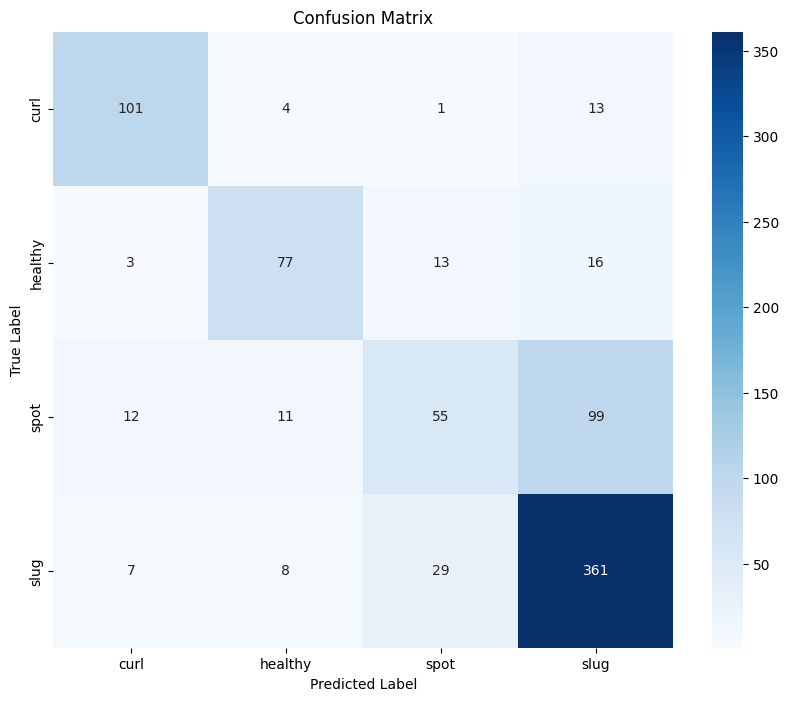

[INFO] Visualizing feature space...


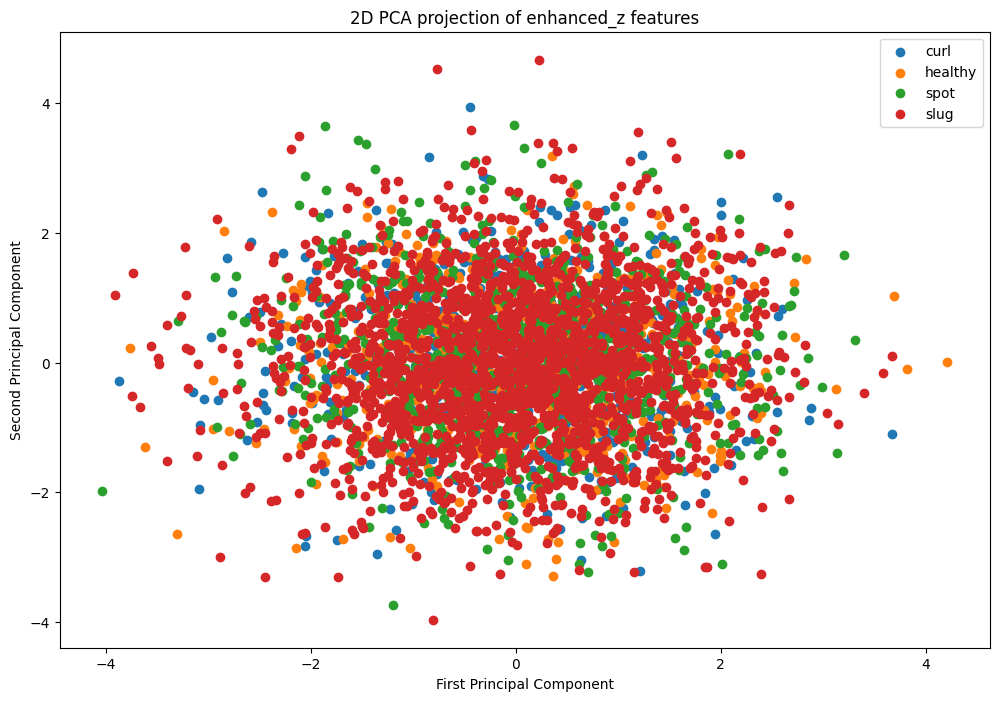

[INFO] Displaying SVM classified images...


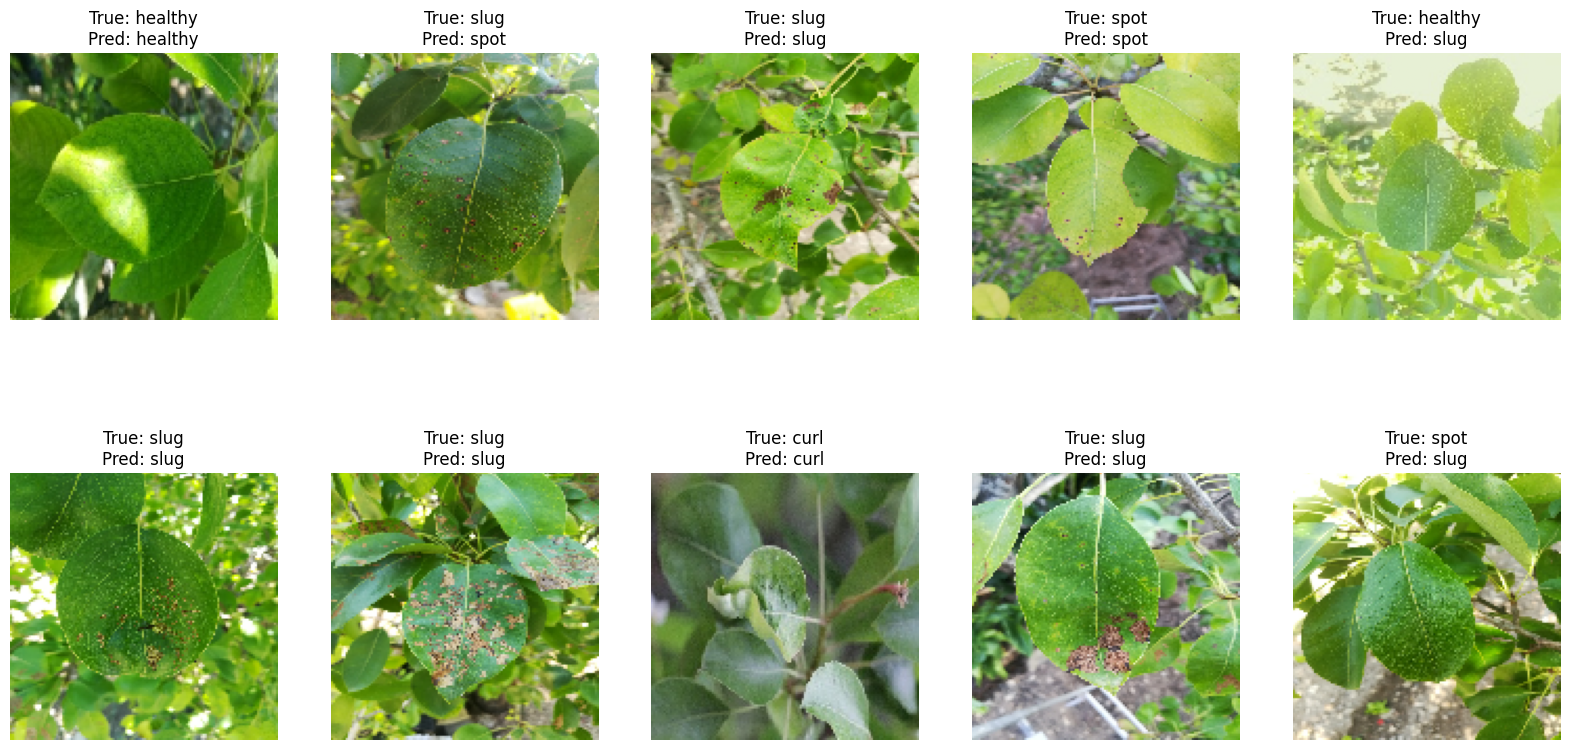

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda, concatenate
import tensorflow.keras.backend as K
import tensorflow as tf

# Define the dataset path (update this path to your dataset's location)
DATASET_PATH = '/content/drive/MyDrive/pear'

# Specify the shape of the inputs for our network
IMG_SHAPE = (128, 128, 3)

# Function to load images from a directory and their labels
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            class_names.append(label)
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=(IMG_SHAPE[0], IMG_SHAPE[1]))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load the dataset
print("[INFO] loading pear leaf dataset...")
images, labels, class_names = load_images_from_folder(DATASET_PATH)

# Normalize the images
images = images / 255.0

# Encode the labels as integers
label_mapping = {label: idx for idx, label in enumerate(class_names)}
labels = np.array([label_mapping[label] for label in labels])

# Function to build the SCNN feature extractor
def build_scnn_feature_extractor(inputShape, embeddingDim=48):
    inputs = Input(inputShape)

    # First set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    pooledOutput1 = GlobalAveragePooling2D()(x)
    encoded1 = Dense(embeddingDim, name='dense')(pooledOutput1)

    # Second set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput2 = GlobalAveragePooling2D()(x)
    encoded2 = Dense(embeddingDim, name='dense_1')(pooledOutput2)

    # Concatenate both encoders
    concatenated = concatenate([encoded1, encoded2])

    model = Model(inputs, concatenated)
    return model

# Sampling function (from VAE)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_combined_model(inputShape, latent_dim):
    # Inputs
    imgA = Input(shape=inputShape)
    imgB = Input(shape=inputShape)

    # SCNN feature extractor (shared weights)
    scnn_feature_extractor = build_scnn_feature_extractor(inputShape)

    # Extract features
    featsA = scnn_feature_extractor(imgA)
    featsB = scnn_feature_extractor(imgB)

    # Concatenate features from both inputs
    concatenated = concatenate([featsA, featsB])

    # VAE layers
    x = Dense(256, activation='relu')(concatenated)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Sampling
    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # Get SCNN encodings directly from the feature extractor
    scnn_encodings = scnn_feature_extractor(imgA)

    # Concatenate z with SCNN encodings
    enhanced_z = concatenate([z, scnn_encodings], name='enhanced_z')

    # Decoder
    decoder_input = Input(shape=(latent_dim + 2*48,))  # 48 is the embedding dimension from SCNN
    x = Dense(256, activation='relu')(decoder_input)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(inputShape[0] * inputShape[1] * inputShape[2], activation='sigmoid')(x)
    decoded_reshaped = tf.keras.layers.Reshape(inputShape)(decoded)

    # Define models
    encoder = Model([imgA, imgB], [z_mean, z_log_var, z, scnn_encodings, enhanced_z], name='encoder')
    decoder = Model(decoder_input, decoded_reshaped, name='decoder')

    # Combined model
    outputs = decoder(encoder([imgA, imgB])[4])  # Use enhanced_z
    combined_model = Model([imgA, imgB], outputs, name='combined_scnn_vae')

    return combined_model, encoder, decoder

# Build the model
latent_dim = 48 + 2 * 48
combined_model, encoder, decoder = build_combined_model(IMG_SHAPE, latent_dim)

# Loss function
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(
        K.flatten(inputs), K.flatten(outputs)) * IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# Compile the model
print("[INFO] compiling model...")
combined_model.compile(optimizer='adam', loss=lambda x, y: vae_loss(x, y, encoder([x, x])[0], encoder([x, x])[1]))

# Train the model (you may want to add this step)
# history = combined_model.fit([images, images], images, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# Function to extract enhanced_z features
def extract_enhanced_z(X, encoder):
    return encoder.predict([X, X])[4]  # enhanced_z is the 5th output

# Extract enhanced_z features for all images
print("[INFO] Extracting enhanced_z features...")
enhanced_z = extract_enhanced_z(images, encoder)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    enhanced_z, labels, test_size=0.2, stratify=labels, random_state=42)

# Create an SVM classifier
print("[INFO] Training SVM classifier...")
clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', decision_function_shape='ovr'))

# Train the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix
print("[INFO] Plotting confusion matrix...")
plot_confusion_matrix(y_test, y_pred, class_names)

# Function to visualize feature space
def plot_feature_space(X, y, classes):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(classes):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=class_name)
    plt.legend()
    plt.title('2D PCA projection of enhanced_z features')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Visualize feature space
print("[INFO] Visualizing feature space...")
plot_feature_space(enhanced_z, labels, class_names)

# Function to display SVM classified images
def display_classified_images(images, y_true, y_pred, class_names, n=10):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(len(images), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, n//2, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.show()

# Display SVM classified images
print("[INFO] Displaying SVM classified images...")
display_classified_images(images, labels, clf.predict(enhanced_z), class_names)


[INFO] loading pear leaf dataset...
[INFO] building SCNN feature extractor...
[INFO] extracting features...
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
[INFO] Training SVM classifier...
Accuracy: 76.31%

Classification Report:
              precision    recall  f1-score   support

        curl       0.88      0.93      0.91       149
     healthy       0.74      0.73      0.73       136
        spot       0.59      0.40      0.48       221
        slug       0.78      0.88      0.83       507

    accuracy                           0.76      1013
   macro avg       0.75      0.74      0.74      1013
weighted avg       0.75      0.76      0.75      1013

[INFO] Plotting confusion matrix...


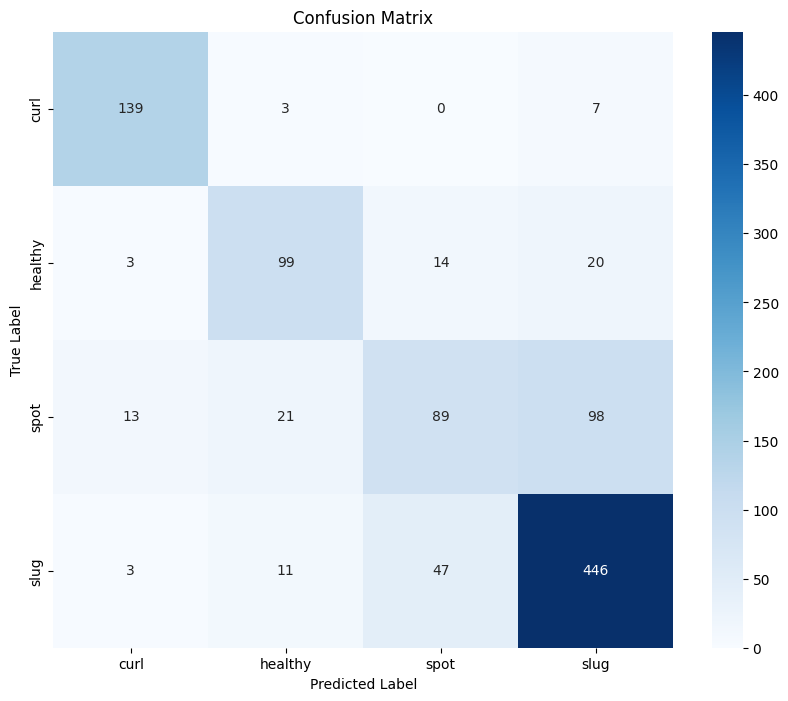

[INFO] Visualizing feature space...


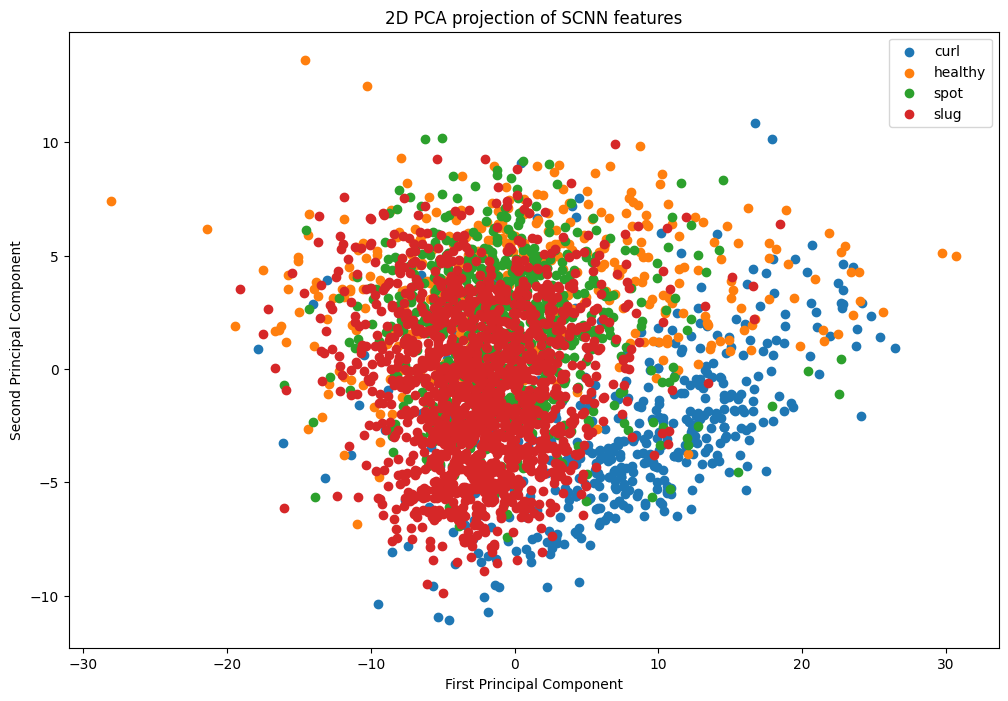

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the dataset path (update this path to your dataset's location in Google Drive)
DATASET_PATH = '/content/drive/MyDrive/pear'

# Specify the shape of the inputs for our network
IMG_SHAPE = (128, 128, 3)

# Load the dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            class_names.append(label)
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=(IMG_SHAPE[0], IMG_SHAPE[1]))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Function to build the SCNN feature extractor
def build_scnn_feature_extractor(inputShape, embeddingDim=48):
    inputs = Input(inputShape)

    # First set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    pooledOutput1 = GlobalAveragePooling2D()(x)
    encoded1 = Dense(embeddingDim, name='dense')(pooledOutput1)

    # Second set of layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput2 = GlobalAveragePooling2D()(x)
    encoded2 = Dense(embeddingDim, name='dense_1')(pooledOutput2)

    # Concatenate both encoders
    concatenated = concatenate([encoded1, encoded2])

    model = Model(inputs, concatenated)
    return model


# Load the dataset
print("[INFO] loading pear leaf dataset...")
images, labels, class_names = load_images_from_folder(DATASET_PATH)

# Normalize the images
images = images / 255.0

# Encode the labels as integers
label_mapping = {label: idx for idx, label in enumerate(class_names)}
labels = np.array([label_mapping[label] for label in labels])

# Split the dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)

# Build the SCNN feature extractor
print("[INFO] building SCNN feature extractor...")
scnn_feature_extractor = build_scnn_feature_extractor(IMG_SHAPE)

# Extract features from the training and testing sets
print("[INFO] extracting features...")
train_features = scnn_feature_extractor.predict(trainX)
test_features = scnn_feature_extractor.predict(testX)

# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Train the SVM classifier
print("[INFO] Training SVM classifier...")
clf = svm.SVC(kernel='linear', decision_function_shape='ovr')
clf.fit(train_features, trainY)

# Predict on the test data
y_pred = clf.predict(test_features)

# Evaluate the model
accuracy = accuracy_score(testY, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, y_pred, target_names=class_names))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix
print("[INFO] Plotting confusion matrix...")
plot_confusion_matrix(testY, y_pred, class_names)

# Function to visualize feature space
def plot_feature_space(X, y, classes):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(classes):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=class_name)
    plt.legend()
    plt.title('2D PCA projection of SCNN features')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Visualize feature space
print("[INFO] Visualizing feature space...")
plot_feature_space(train_features, trainY, class_names)
